In [271]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import matplotlib.pyplot as plt
import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

0it [00:00, ?it/s]

In [272]:
COLUMN_OF_INTEREST =['QUOTE_UNIXTIME','QUOTE_DATE','EXPIRE_DATE','EXPIRE_UNIX',
                            'DTE','C_BID','C_ASK', 'P_BID','P_ASK',
                             'UNDERLYING_LAST','STRIKE','STRIKE_DISTANCE']

In [273]:
df_options_spx = pd.read_csv('data/2020-2022_SPX_30days.csv')

# convert QUOTE_DATE and EXPIRE_DATE to datetime
df_options_spx['QUOTE_DATE'] = pd.to_datetime(df_options_spx['QUOTE_DATE'])
df_options_spx['EXPIRE_DATE'] = pd.to_datetime(df_options_spx['EXPIRE_DATE'])

# drop QUOTE_UNIXTIME and EXPIRE_UNIX
df_options_spx = df_options_spx.drop(['QUOTE_UNIXTIME', 'EXPIRE_UNIX'], axis=1)

# set "" to NaN
df_options_spx = df_options_spx.replace(r'^\s*$', np.nan, regex=True)

# drop rows with NaN
df_options_spx = df_options_spx.dropna()

# convert C_BID, C_ASK, P_BID, P_ASK to float
df_options_spx['C_BID'] = df_options_spx['C_BID'].astype(float)
df_options_spx['C_ASK'] = df_options_spx['C_ASK'].astype(float)
df_options_spx['P_BID'] = df_options_spx['P_BID'].astype(float)
df_options_spx['P_ASK'] = df_options_spx['P_ASK'].astype(float)

In [274]:
df_options_spx.dtypes

QUOTE_DATE         datetime64[ns]
EXPIRE_DATE        datetime64[ns]
DTE                       float64
C_BID                     float64
C_ASK                     float64
P_BID                     float64
P_ASK                     float64
UNDERLYING_LAST           float64
STRIKE                    float64
STRIKE_DISTANCE           float64
dtype: object

In [275]:
df_options_spx.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE
0,2020-01-03,2020-01-03,0.0,1826.61,1849.20,0.0,0.05,3234.35,1400.0,1834.3
1,2020-01-03,2020-01-03,0.0,1726.60,1749.30,0.0,0.05,3234.35,1500.0,1734.3
2,2020-01-03,2020-01-03,0.0,1626.60,1649.19,0.0,0.04,3234.35,1600.0,1634.3
3,2020-01-03,2020-01-03,0.0,1526.60,1549.31,0.0,0.05,3234.35,1700.0,1534.3
4,2020-01-03,2020-01-03,0.0,1426.60,1449.30,0.0,0.04,3234.35,1800.0,1434.3


In [276]:
# Calculate the rolling volatility of the underlying price
import yfinance as yf
from pypfopt.risk_models import CovarianceShrinkage

TICKER = ['SPY']

start_date = '2017-01-01' # you need to have at least 2 years of data before the start date as we are calculating the rolling volatility of 2 years
end_date = '2023-01-01' # end date is exclusive, the data will be downloaded until 2022-12-31

df = yf.download(TICKER, start=start_date, end=end_date)

# calculate the rolling volatility of 2 years (252 trading days per year)
# rolling_period = 252*2
rolling_period = int(252)
# dt = 1/252

# VOLATILITY METHOD 1: calculate the volatility using log return and take the standard deviation as is
# df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# df['volatility'] = df['log_return'].rolling(rolling_period).std() * np.sqrt(252)

# VOLATILITY METHOD 2: calculate the volatility using log return and CovarianceShrinkage
df_spy = df['Adj Close']
df_spy.index.name = None
df['volatility'] = np.nan

#Apply rolling period of 2 years to CovarianceShrinkage
for i in range(rolling_period, len(df_spy)):
    cov_matrix = CovarianceShrinkage(df_spy.iloc[i-rolling_period:i], log_returns=True).ledoit_wolf() 

    #calculate the volatility. cov_matrix is annualized, so no need to multiply by sqrt(252)
    df['volatility'].iloc[i] = np.sqrt(cov_matrix.iloc[0,0])
    
# we only need the data from 2020 to 2022
df = df.loc['2020-01-01':'2022-12-31']

[*********************100%***********************]  1 of 1 completed


In [277]:
# risk free rate for 2020 to 2022 is around 2.5% per annum
risk_free_rate = 0.025

# dividend yield is rate is roughly 1.5% per annum for SPY
dividend_yield = 0.015

In [278]:
def binomial_model(S0, K, T, r, sigma, N, 
                   option='call', div=0, 
                   european=True, method='crr'):
    ''' Binomial model for option pricing.
    Parameters
    ==========
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term 
    N : int
        number of time intervals
    option : string
        type of the option to be valued ('call' or 'put')
    div : float
        annualized continuous dividend yield
    european : boolean
        True for European option valuation
        False for American option valuation
    method : string
        'crr' for Cox, Ross and Rubinstein
        'jr' for Jarrow and Rudd/equal probabilities 
    Returns
    =======
    value : float
        present value of the European option
    '''
    dt = T / N
    
    # calculate the risk-neutral probability
    if method == 'crr':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - div) * dt) - d) / (u - d)
    elif method == 'jr':
        u = np.exp((r-div-0.5*sigma**2)*dt+sigma*np.sqrt(dt))
        d = np.exp((r-div-0.5*sigma**2)*dt-sigma*np.sqrt(dt))
        p = 0.5
    else:
        raise ValueError('method not recognized')

    q = 1 - p

    # initialize terminal stock prices at maturity
    stock_prices = np.zeros((N + 1, N + 1))
    stock_prices[0, 0] = S0
    for i in range(1, N + 1):
        stock_prices[0, i] = stock_prices[0, i - 1] * u
        for j in range(1, i + 1):
            stock_prices[j, i] = stock_prices[j - 1, i - 1] * d

    # calculate option values at maturity
    option_values = np.zeros((N + 1, N + 1))
    if option == 'call':
        option_values[:, N] = np.maximum(stock_prices[:, N] - K, 0)
    else:
        option_values[:, N] = np.maximum(K - stock_prices[:, N], 0)

    # backward induction
    if european:
        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + q * option_values[j + 1, i + 1])
    else:
        if option == 'call':
            for i in range(N - 1, -1, -1):
                for j in range(i + 1):
                    option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + q * option_values[j + 1, i + 1])
                    option_values[j, i] = np.maximum(option_values[j, i], stock_prices[j, i] - K)
        else:
            for i in range(N - 1, -1, -1):
                for j in range(i + 1):
                    option_values[j, i] = np.exp(-r * dt) * (p * option_values[j, i + 1] + q * option_values[j + 1, i + 1])
                    option_values[j, i] = np.maximum(option_values[j, i], K - stock_prices[j, i])
    
    return option_values[0, 0]

In [279]:
S0 = 3246.23
K = 2000
T = 21/252
r = 0.025
div = 0.015
sigma = 0.1498878078948466
N = 21
print(binomial_model(S0, K, T, r, sigma, N, option='call', div=div, european=True, method='crr'))
print(binomial_model(S0, K, T, r, sigma, N, option='call', div=div, european=True, method='jr'))

1246.3370769621977
1246.3370318672155


In [280]:
# merge the dataframes of df_options and df where df_options QUOTE_DATE is same as df index
df_model_input = df_options_spx.merge(df['volatility'], left_on='QUOTE_DATE', right_on=df.index)
df_model_input = df_model_input[df_model_input['DTE']==30]

In [281]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility
382,2020-01-06,2020-02-05,30.0,1241.90,1248.39,0.00,0.14,3246.23,2000.0,1246.2,0.119088
383,2020-01-06,2020-02-05,30.0,1142.89,1148.59,0.10,0.16,3246.23,2100.0,1146.2,0.119088
384,2020-01-06,2020-02-05,30.0,1092.10,1098.70,0.10,0.20,3246.23,2150.0,1096.2,0.119088
385,2020-01-06,2020-02-05,30.0,1043.10,1048.80,0.05,0.20,3246.23,2200.0,1046.2,0.119088
386,2020-01-06,2020-02-05,30.0,993.20,998.91,0.10,0.21,3246.23,2250.0,996.2,0.119088


In [282]:
# backtest the binomial model
# track the progress of the backtest
N_PLUS=0
df_model_input['binomial_model_crr_call'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=True, method='crr'), axis=1)

  0%|          | 0/38928 [00:00<?, ?it/s]

In [283]:
# backtest the binomial model
# track the progress of the backtest

N_PLUS=0
df_model_input['binomial_model_crr_put'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=True, method='crr'), axis=1)

  0%|          | 0/38928 [00:00<?, ?it/s]

In [284]:
df_model_input['binomial_model_jr_call'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=True, method='jr'), axis=1)


  0%|          | 0/38928 [00:00<?, ?it/s]

In [285]:
df_model_input['binomial_model_jr_put'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=True, method='jr'), axis=1)


  0%|          | 0/38928 [00:00<?, ?it/s]

In [289]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility,binomial_model_crr_call,binomial_model_crr_put,binomial_model_jr_call,binomial_model_jr_put
382,2020-01-06,2020-02-05,30.0,1241.90,1248.39,0.00,0.14,3246.23,2000.0,1246.2,0.119088,1246.335634,0.0,1246.335622,0.0
383,2020-01-06,2020-02-05,30.0,1142.89,1148.59,0.10,0.16,3246.23,2100.0,1146.2,0.119088,1146.540903,0.0,1146.540891,0.0
384,2020-01-06,2020-02-05,30.0,1092.10,1098.70,0.10,0.20,3246.23,2150.0,1096.2,0.119088,1096.643537,0.0,1096.643525,0.0
385,2020-01-06,2020-02-05,30.0,1043.10,1048.80,0.05,0.20,3246.23,2200.0,1046.2,0.119088,1046.746171,0.0,1046.746159,0.0
386,2020-01-06,2020-02-05,30.0,993.20,998.91,0.10,0.21,3246.23,2250.0,996.2,0.119088,996.848806,0.0,996.848793,0.0


In [290]:
df_eval = df_model_input[['QUOTE_DATE', 
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_eval['C_PRICE'] = (df_eval['C_BID'] + df_eval['C_ASK'])/2
df_eval['P_PRICE'] = (df_eval['P_BID'] + df_eval['P_ASK'])/2
df_eval = df_eval.set_index('QUOTE_DATE')
df_eval.head()

,binomial_model_crr_call,binomial_model_jr_call,C_BID,C_ASK,binomial_model_crr_put,binomial_model_jr_put,P_BID,P_ASK,DTE,STRIKE,C_PRICE,P_PRICE
QUOTE_DATE,,,,,,,,,,,,
2020-01-06,1246.335634,1246.335622,1241.90,1248.39,0.0,0.0,0.00,0.14,30.0,2000.0,1245.145,0.070
2020-01-06,1146.540903,1146.540891,1142.89,1148.59,0.0,0.0,0.10,0.16,30.0,2100.0,1145.740,0.130
2020-01-06,1096.643537,1096.643525,1092.10,1098.70,0.0,0.0,0.10,0.20,30.0,2150.0,1095.400,0.150
2020-01-06,1046.746171,1046.746159,1043.10,1048.80,0.0,0.0,0.05,0.20,30.0,2200.0,1045.950,0.125
2020-01-06,996.848806,996.848793,993.20,998.91,0.0,0.0,0.10,0.21,30.0,2250.0,996.055,0.155


In [294]:
#calculate absolute error of binomial model
df_eval['binomial_model_crr_call_error'] = df_eval['binomial_model_crr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_jr_call_error'] = df_eval['binomial_model_jr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_crr_put_error'] = df_eval['binomial_model_crr_put'] - df_eval['P_PRICE']
df_eval['binomial_model_jr_put_error'] = df_eval['binomial_model_jr_put'] - df_eval['P_PRICE']

#calculate root mean squared error of binomial model
print('Root Mean Squared Error of CRR Call model:',np.sqrt(np.mean(df_eval['binomial_model_crr_call_error']**2)))
print('Root Mean Squared Error of JR Call model:',np.sqrt(np.mean(df_eval['binomial_model_jr_call_error']**2)))
print('Root Mean Squared Error of CRR Put model:',np.sqrt(np.mean(df_eval['binomial_model_crr_put_error']**2)))
print('Root Mean Squared Error of JR Put model:',np.sqrt(np.mean(df_eval['binomial_model_jr_put_error']**2)))

#calculate mean absolute error of binomial model
print('Mean Absolute Error of CRR Call model:',np.mean(np.abs(df_eval['binomial_model_crr_call_error'])))
print('Mean Absolute Error of JR Call model:',np.mean(np.abs(df_eval['binomial_model_jr_call_error'])))
print('Mean Absolute Error of CRR Put model:',np.mean(np.abs(df_eval['binomial_model_crr_put_error'])))
print('Mean Absolute Error of JR Put model:',np.mean(np.abs(df_eval['binomial_model_jr_put_error'])))

#calculate mean absolute percentage error of binomial model
print('Percentage Mean Absolute Error of CRR Call model:', np.mean(np.abs(df_eval['binomial_model_crr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Call model:', np.mean(np.abs(df_eval['binomial_model_jr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of CRR Put model:', np.mean(np.abs(df_eval['binomial_model_crr_put_error']/df_eval['P_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Put model:', np.mean(np.abs(df_eval['binomial_model_jr_put_error']/df_eval['P_PRICE']))*100,'%')


Root Mean Squared Error of CRR Call model: 20.89449508076966
Root Mean Squared Error of JR Call model: 20.892574132157655
Root Mean Squared Error of CRR Put model: 21.618769521842342
Root Mean Squared Error of JR Put model: 21.61698627984962
Mean Absolute Error of CRR Call model: 12.179501563308133
Mean Absolute Error of JR Call model: 12.178586158075358
Mean Absolute Error of CRR Put model: 13.38102036718174
Mean Absolute Error of JR Put model: 13.379551854622415
Percentage Mean Absolute Error of CRR Call model: 89.90172995302787 %
Percentage Mean Absolute Error of JR Call model: 89.7480232167664 %
Percentage Mean Absolute Error of CRR Put model: 52.080371613710795 %
Percentage Mean Absolute Error of JR Put model: 52.073424139421796 %


In [295]:
df_input = df_model_input[['QUOTE_DATE', 'EXPIRE_DATE',
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_input['C_PRICE'] = (df_input['C_BID'] + df_input['C_ASK'])/2
df_input['P_PRICE'] = (df_input['P_BID'] + df_input['P_ASK'])/2
df_input.drop(['C_BID','C_ASK', 'P_BID','P_ASK',], axis=1, inplace=True)
df_input = df_input.set_index('QUOTE_DATE')
df_input.tail()

,EXPIRE_DATE,binomial_model_crr_call,binomial_model_jr_call,binomial_model_crr_put,binomial_model_jr_put,DTE,STRIKE,C_PRICE,P_PRICE
QUOTE_DATE,,,,,,,,,
2022-12-28,2023-01-27,1.265117,1.270221,613.844464,613.849807,30.0,4400.0,0.450,602.90
2022-12-28,2023-01-27,0.172085,0.166432,812.340895,812.335481,30.0,4600.0,0.150,801.80
2022-12-28,2023-01-27,0.014225,0.014279,1011.772498,1011.772792,30.0,4800.0,0.075,1000.65
2022-12-28,2023-01-27,0.000516,0.000538,1211.348252,1211.348513,30.0,5000.0,0.050,1200.05
2022-12-28,2023-01-27,0.000024,0.000023,1410.937223,1410.937462,30.0,5200.0,0.025,1399.05


In [296]:
df_price = df_model_input[['QUOTE_DATE', 'UNDERLYING_LAST']]
df_price = df_price.drop_duplicates()
df_price = df_price.set_index('QUOTE_DATE')

# remove rows where expiry date is greater max quote date
df_input = df_input[df_input['EXPIRE_DATE'] <= df_input.index.max()]
df_input['UNDERLYING_PRICE_EXPIRE'] = df_input['EXPIRE_DATE'].progress_apply(
    lambda x: df_price.loc[x]['UNDERLYING_LAST'] if x in df_price.index 
    else df_price.loc[df_price.index[df_price.index.get_loc(x, method='bfill')]]['UNDERLYING_LAST'])

  0%|          | 0/37131 [00:00<?, ?it/s]

In [297]:
df_binomial_model_crr = df_input[['binomial_model_crr_call', 'binomial_model_crr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_crr = df_binomial_model_crr.rename(columns={'binomial_model_crr_call':'call', 'binomial_model_crr_put':'put'})

df_binomial_model_jr = df_input[['binomial_model_jr_call', 'binomial_model_jr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_jr = df_binomial_model_jr.rename(columns={'binomial_model_jr_call':'call', 'binomial_model_jr_put':'put'})

In [298]:
df_binomial_model_crr['long_call'] = np.where(df_binomial_model_crr['call'] > df_binomial_model_crr['C_PRICE'], 1, -1)
df_binomial_model_crr['long_put'] = np.where(df_binomial_model_crr['put'] > df_binomial_model_crr['P_PRICE'], 1, -1)
df_binomial_model_crr['PROFIT_LOSS_ON_PURCHASE'] = -1*(df_binomial_model_crr['long_call']*df_binomial_model_crr['C_PRICE'] + df_binomial_model_crr['long_put']*df_binomial_model_crr['P_PRICE'])

df_binomial_model_jr['long_call'] = np.where(df_binomial_model_jr['call'] > df_binomial_model_jr['C_PRICE'], 1, -1)
df_binomial_model_jr['long_put'] = np.where(df_binomial_model_jr['put'] > df_binomial_model_jr['P_PRICE'], 1, -1)
df_binomial_model_jr['PROFIT_LOSS_ON_PURCHASE'] = -1*(df_binomial_model_jr['long_call']*df_binomial_model_jr['C_PRICE'] + df_binomial_model_jr['long_put']*df_binomial_model_jr['P_PRICE'])

In [299]:
df_binomial_model_crr['PROFIT_LOSS_ON_SALE'] = (df_binomial_model_crr['long_call']*np.maximum(df_binomial_model_crr['UNDERLYING_PRICE_EXPIRE'] - df_binomial_model_crr['STRIKE'], 0) + 
                                        df_binomial_model_crr['long_put']*np.maximum(df_binomial_model_crr['STRIKE'] - df_binomial_model_crr['UNDERLYING_PRICE_EXPIRE'], 0))
df_binomial_model_crr['PROFIT_LOSS'] = df_binomial_model_crr['PROFIT_LOSS_ON_SALE'] + df_binomial_model_crr['PROFIT_LOSS_ON_PURCHASE']

df_binomial_model_jr['PROFIT_LOSS_ON_SALE'] = (df_binomial_model_jr['long_call']*np.maximum(df_binomial_model_jr['UNDERLYING_PRICE_EXPIRE'] - df_binomial_model_jr['STRIKE'], 0) +
                                        df_binomial_model_jr['long_put']*np.maximum(df_binomial_model_jr['STRIKE'] - df_binomial_model_jr['UNDERLYING_PRICE_EXPIRE'], 0))
df_binomial_model_jr['PROFIT_LOSS'] = df_binomial_model_jr['PROFIT_LOSS_ON_SALE'] + df_binomial_model_jr['PROFIT_LOSS_ON_PURCHASE']

In [300]:
df_binomial_model_crr.tail()

,call,put,DTE,STRIKE,C_PRICE,P_PRICE,EXPIRE_DATE,UNDERLYING_PRICE_EXPIRE,long_call,long_put,PROFIT_LOSS_ON_PURCHASE,PROFIT_LOSS_ON_SALE,PROFIT_LOSS
QUOTE_DATE,,,,,,,,,,,,,
2022-11-28,8.113005,439.405994,30.0,4400.0,1.175,426.30,2022-12-28,3783.05,1,1,-427.475,616.95,189.475
2022-11-28,3.520347,534.608067,30.0,4500.0,0.775,526.15,2022-12-28,3783.05,1,1,-526.925,716.95,190.025
2022-11-28,1.498265,632.380716,30.0,4600.0,0.600,624.85,2022-12-28,3783.05,1,1,-625.450,816.95,191.500
2022-11-28,0.222327,830.694242,30.0,4800.0,0.525,823.95,2022-12-28,3783.05,-1,1,-823.425,1016.95,193.525
2022-11-28,0.018767,1030.080144,30.0,5000.0,0.525,1023.25,2022-12-28,3783.05,-1,1,-1022.725,1216.95,194.225


Mean Profit/Loss of CRR model: 8.959887290942877
Mean Profit/Loss of JR model: 8.900853060784788
Volatility of CRR model: 207.2139025439408
Volatility of JR model: 207.2486516839786
Total Profit/Loss of CRR model: 332689.57499999995
Total Profit/Loss of JR model: 330497.57499999995
Plotting daily Profit/Loss of CRR model


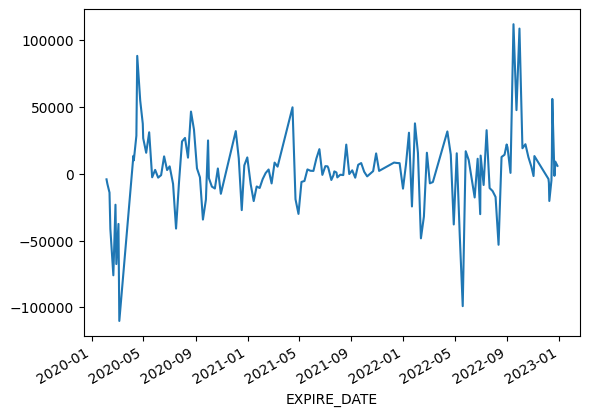

Plotting daily Profit/Loss of JR model


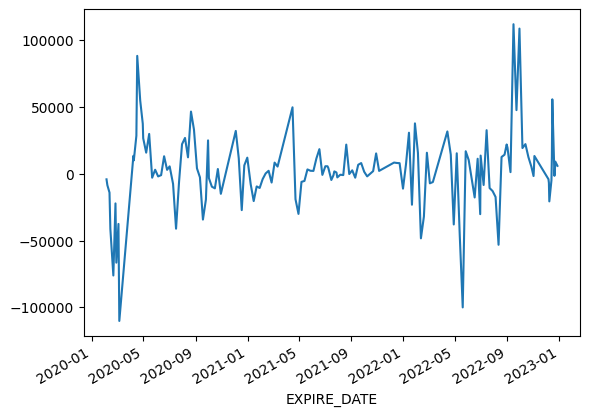

Plotting Cumulative Profit/Loss of CRR model


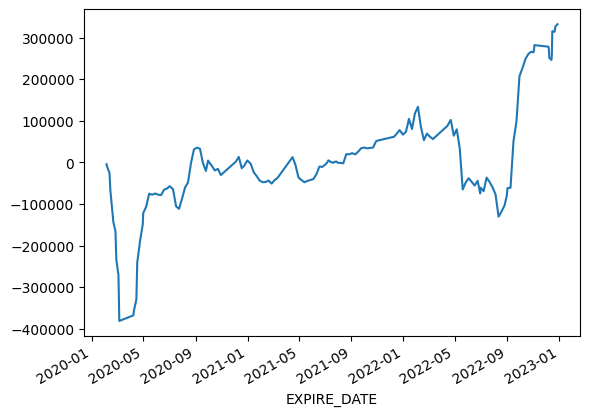

Plotting Cumulative Profit/Loss of JR model


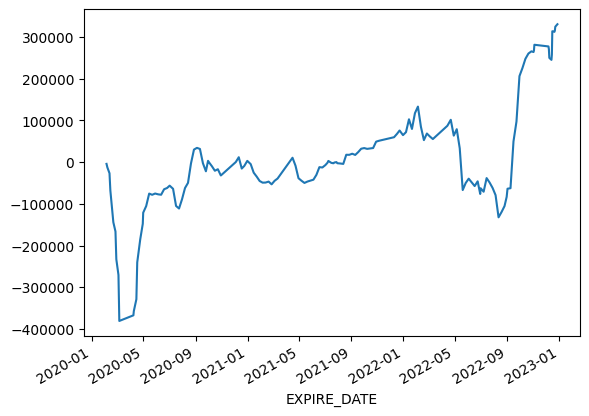

In [301]:
print('Mean Profit/Loss of CRR model:',np.mean(df_binomial_model_crr['PROFIT_LOSS']))
print('Mean Profit/Loss of JR model:',np.mean(df_binomial_model_jr['PROFIT_LOSS']))
print('Volatility of CRR model:',np.std(df_binomial_model_crr['PROFIT_LOSS']))
print('Volatility of JR model:',np.std(df_binomial_model_jr['PROFIT_LOSS']))
print('Total Profit/Loss of CRR model:',np.sum(df_binomial_model_crr['PROFIT_LOSS']))
print('Total Profit/Loss of JR model:',np.sum(df_binomial_model_jr['PROFIT_LOSS']))

print('Plotting daily Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting daily Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting Cumulative Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()

print('Plotting Cumulative Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()